In [11]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from collections import Counter

# BoTorch / GPyTorch 関連
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from mpl_toolkits.mplot3d import Axes3D  # 必要に応じて

# Plot周りの設定
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
plt.rcParams["figure.dpi"] = 100  # 高解像度設定

In [12]:
# 2. Styblinski-Tang 関数 + ノイズ
# ※ 本関数は、入力の最初の5次元のみを用いて Styblinski-Tang 関数の値を計算し、
# それ以外の次元は無視します。
# f(x) = 0.5 * sum_{i=0}^{4} (x_i^4 - 16x_i^2 + 5x_i)
# ノイズとして正規分布に従う項を加えます。

def styblinski_tang(x, noise_std=0.001):
    """
    x: shape (..., d) のテンソル（d>=5を仮定）
       目的関数の計算には最初の5次元のみを利用する。
    noise_std: ノイズの標準偏差
    """
    # 最初の5次元を抽出
    if torch.is_tensor(x):
        x_val = x[..., :5]  # shape (..., 5)
    else:
        x_val = torch.tensor(x[..., :5], dtype=torch.float32)

    # 各次元ごとに Styblinski-Tang 関数を計算し、全次元で和を取る
    # f_i(x) = 0.5*(x_i^4 - 16x_i^2 + 5x_i)
    result = 0.5 * torch.sum(x_val ** 4 - 16 * x_val ** 2 + 5 * x_val, dim=-1)

    # ノイズを加える
    noise = torch.randn_like(result) * noise_std
    result_noisy = result + noise
    return result_noisy


In [13]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, coordinate_ratio=0.5):
        """
        X: 初期サンプル点 (n_initial, dim)
        objective_function: 目的関数 (styblinski_tang など)
        bounds: 探索の下限・上限 (2, dim) のテンソル
        n_initial: 初期サンプル数
        n_max: 反復最大回数
        dim: 入力次元 (ここでは例として100)
        """
        dtype = torch.float
        self.num_arms = dim  # 各イテレーションで生成される候補方向の数

        # 線形バンディット用のパラメータ A, b の初期化
        self.A = torch.eye(dim, dtype=dtype)
        self.b = torch.zeros(dim, dtype=dtype)

        self.objective_function = objective_function
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []        # 各反復でのbest_valueの履歴
        self.arm_selection_history = []  # 選択された arm のインデックスの履歴
        self.optimization_history = []   # 探索した新しい点の履歴
        self.saved_plot_files = []       # GP後方分布のプロット保存用

        self.coordinate_ratio = coordinate_ratio

        # ★追加★: UCBおよび線形バンディットの解析用パラメータ
        # 【Abbasi‐Yadkori et al. (2012)】に基づく設定例
        self.sigma = 0.1         # ノイズ標準偏差の仮定
        self.L = 5.0             # 各アーム（特徴ベクトル）のノルム上限
        self.lambda_reg = 1.0    # 正則化パラメータ
        self.delta = 0.1         # 失敗確率
        self.S = 10.0            # 真のパラメータのノルム上限

        # ★追加★: 選択された方向（実際のベクトル）と推定θの履歴を記録
        self.selected_direction_history = []  # 各イテレーションで選ばれた方向のベクトル
        self.theta_history = []                 # 各イテレーションでの推定パラメータ theta

        self.reward_history = []   # 各イテレーションの更新量（報酬）を記録
        self.iteration_table_data = []

        # ★変更★: 選択された方向の絶対値を累積（後で棒グラフで可視化）
        self.direction_sum_abs = torch.zeros(dim, dtype=dtype)

    def update_model(self):
        """
        BoTorchのSingleTaskGPを更新する。
        """
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        """
        初期点 X に対して目的関数を評価し、GPモデルを初期化する。
        GPの事後平均を用いて best_value と best_point を更新する。
        """
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)

        # GPモデル更新
        self.update_model()
        # GPの事後平均から最小値（最良の候補）を選ぶ
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index]

        self.eval_history = [self.best_value] * self.n_initial

    def generate_arms(self):
        """
        1イテレーションにつき合計 self.num_arms(=dim) 本の候補方向ベクトルを生成する関数。
        - うち (coordinate_ratio * dim) 本は座標方向ベクトル
        - うち 残りはランダム方向ベクトル
        - 最後に v[0]<0 なら符号反転
        - 結果を (num_arms, dim) の torch.Tensor で返す
        """
        dtype = torch.float
        num_coord = int(math.floor(self.coordinate_ratio * self.dim))
        # 上限をdim以内に収める
        if num_coord > self.dim:
            num_coord = self.dim

        #-------------------------------------------
        # (1) 座標方向ベクトル: num_coord 本
        #-------------------------------------------
        #   ランダムに num_coord 個の次元を選び、その標準基底を作る
        random_indices = np.random.choice(self.dim, num_coord, replace=False)
        coordinate_arms = []
        for idx in random_indices:
            e_i = torch.zeros(self.dim, dtype=dtype)
            e_i[idx] = 1.0
            coordinate_arms.append(e_i)
        if len(coordinate_arms) > 0:
            coordinate_arms = torch.stack(coordinate_arms, dim=0)
        else:
            coordinate_arms = torch.zeros(0, self.dim, dtype=dtype)

        #-------------------------------------------
        # (2) ランダム方向ベクトル: 残り
        #-------------------------------------------
        num_random = self.dim - num_coord
        if num_random > 0:
            random_arms = torch.randn(num_random, self.dim, dtype=dtype)
            random_arms = random_arms / random_arms.norm(dim=1, keepdim=True)
        else:
            random_arms = torch.zeros(0, self.dim, dtype=dtype)

        #-------------------------------------------
        # (3) 結合
        #-------------------------------------------
        arms = torch.cat([coordinate_arms, random_arms], dim=0)

        return arms

    def select_arm(self, total_iterations):
        """
        線形バンディット（LinUCBに基づく）により、候補方向の中から最良と思われる方向を選択する。
        UCB値は以下の形で計算する：
            UCB(x) = x^T * theta + beta_t * sqrt(x^T * A^{-1} * x)
        ここで、beta_t は
            beta_t = sigma * sqrt(dim * log((1 + total_iterations * L^2 / lambda_reg) / delta)) + sqrt(lambda_reg) * S
        と定式化する（【Abbasi‐Yadkori et al. (2012)】参照）。
        また、現在の推定パラメータ theta を記録します。
        """
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        # 計算した theta を履歴に記録
        self.theta_history.append(theta.clone())

        p_values = []

        beta_t = self.sigma * math.sqrt(self.dim * math.log((1 + total_iterations * (self.L ** 2) / self.lambda_reg) / self.delta)) + math.sqrt(self.lambda_reg) * self.S

        for i in range(self.num_arms):
            x_arm = self.arms_features[i].view(-1, 1)  # shape (dim,1)
            mean = (theta.view(1, -1) @ x_arm).item()   # 推定期待報酬
            var = (x_arm.t() @ A_inv @ x_arm).item()      # 不確実性（分散）
            # UCBの計算
            ucb = mean + beta_t * math.sqrt(var)
            p_values.append(ucb)

        # 選ばれた arm のインデックスを返す
        return int(np.argmax(p_values))

    def optimize(self):
        """
        メインの最適化ループ。
        GPによる局所探索と線形バンディットによるグローバル探索（方向選択）を組み合わせる。
        各イテレーションで、推定パラメータ(theta)および選択した方向ベクトルを記録します。
        """
        self.initialize()
        self.optimization_history = []
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        self.update_model()

        while n < self.n_max:
            self.arms_features = self.generate_arms()

            # 線形バンディットで候補方向を選択
            selected_arm = self.select_arm(total_iterations)
            self.arm_selection_history.append(selected_arm)
            direction = self.arms_features[selected_arm]
            # 記録：選択された方向ベクトルを保存
            self.selected_direction_history.append(direction.clone())

            # EI (Expected Improvement) を定義（GPモデルは既に更新済み）
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            # 1次元最適化のための補助関数（best_pointを基準に、選択された方向に沿って最適化）
            def eci_func(x):
                x_scalar = x.squeeze(-1).squeeze(-1)
                full_x = self.best_point.clone().unsqueeze(0)
                full_x = full_x + x_scalar[:, None] * direction
                full_x = full_x.unsqueeze(1)
                return ei(full_x)

            one_d_bounds = torch.tensor([[-5.0], [5.0]], dtype=dtype)
            candidate, acq_value = optimize_acqf(
                eci_func,
                one_d_bounds,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )

            # 新たな評価点を、選択された方向に沿って更新
            new_x = self.best_point.clone() + candidate.squeeze() * direction
            # boundsの範囲に収まるようにクリップする
            new_x = torch.clamp(new_x, self.bounds[0], self.bounds[1])

            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            reward = max(0, self.best_value - new_y.item())

            # データの更新
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.optimization_history.append(new_x.clone())

            # 線形バンディットの情報更新：Aは方向ベクトルの外積で更新
            x_arm = direction.view(-1, 1)
            self.A = self.A + x_arm @ x_arm.t()

            # ★ 報酬 ★
            reward = math.log(1 + reward)
            self.reward_history.append(reward)
            self.b = self.b + reward * direction

            # GPモデルを更新し、GP事後平均の最小値で best_value, best_point を更新する
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index]

            self.eval_history.append(self.best_value)
            self.direction_sum_abs += direction.abs()

            # ★追加★: 各イテレーションの情報を記録する
            # まず、GPモデルのカーネルパラメータ（ここでは ScaleKernel 内の RBFKernel の lengthscale と outputscale）を取得
            kernel = self.model.covar_module
            # RBFKernel の lengthscale を取得（※場合によって shape が異なる場合があります）
            lengthscale = kernel.base_kernel.lengthscale.detach().cpu().numpy()
            outputscale = kernel.outputscale.detach().cpu().numpy()

            iteration_data = {
                "iteration": total_iterations,
                "x": new_x.detach().cpu().numpy(),       # このイテレーションで評価した x の値
                "y": new_y.item(),                         # 対応する目的関数値
                "best_value": self.best_value,             # GP事後平均による最良値
                "kernel_lengthscale": lengthscale,         # カーネルの lengthscale パラメータ
                "kernel_outputscale": outputscale,         # カーネルの outputscale パラメータ
                "reward": reward,                          # 更新時の reward（対数変換済み）
            }
            self.iteration_table_data.append(iteration_data)

            n += 1
            total_iterations += 1

        return self.best_point, self.best_value

In [14]:
def generate_initial_points(n_initial, dim, bounds):
    """
    指定した範囲 bounds の中で一様乱数を用いて初期点を生成する関数。
    bounds: shape (2, dim) のテンソルで、下限と上限が与えられる。
    """
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

In [15]:
if __name__ == "__main__":
    # パラメータ設定
    dim = 50  # 100次元実験
    # 各次元の下限は -5, 上限は 5 とする（100次元分のベクトル）
    bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
    n_initial = 200   # 初期サンプル数
    n_iter = 800     # BOイテレーション数
    n_runs = 1      # 複数試行回数

    # 実験
    eci_bo_bandit_history = []
    arm_selection_history = []
    bandit_list = []

    try:
        with tqdm.notebook.tqdm(total=n_runs, bar_format=TQDM_BAR_FORMAT) as pbar:
            with io.capture_output() as captured:
                for run in range(n_runs):
                    X_init = generate_initial_points(n_initial, dim, bounds)
                    # ECI_BO_Bandit インスタンス生成
                    eci_bo_bandit = ECI_BO_Bandit(
                        X_init,
                        objective_function=styblinski_tang,  # styblinski_tang 関数を目的関数に
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim,
                        coordinate_ratio=0.8
                    )
                    best_x, best_f = eci_bo_bandit.optimize()

                    # 各試行の評価履歴を保存
                    eci_bo_bandit_history.append(eci_bo_bandit.eval_history)
                    arm_selection_history.append(eci_bo_bandit.arm_selection_history)
                    bandit_list.append(eci_bo_bandit)

                    pbar.update(1)
    except subprocess.CalledProcessError:
        print(captured)
        raise

  0%|          | 0/1 [elapsed: 00:00 remaining: ?]

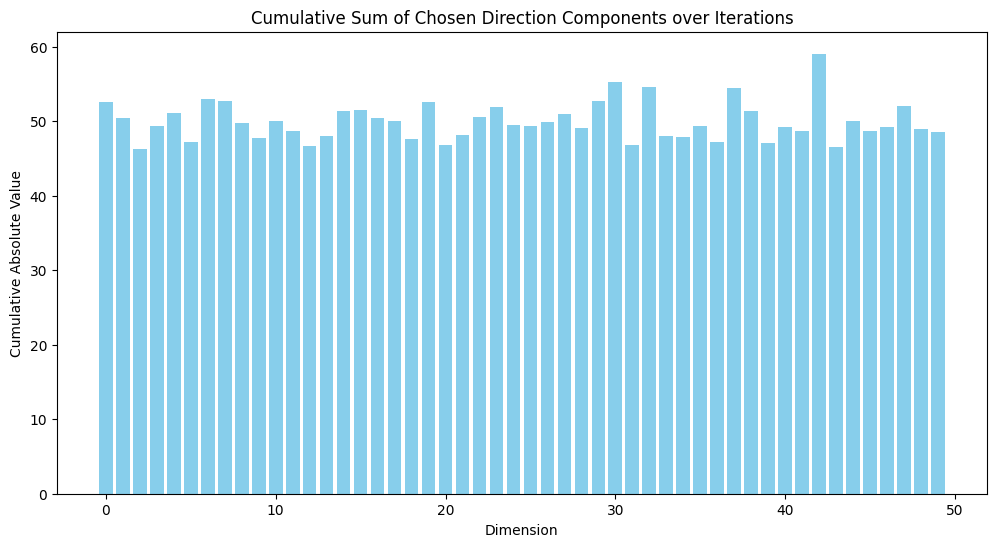

In [16]:
# 3. 選択された方向の各次元の累積和を棒グラフで表示
direction_sums_abs = bandit_list[0].direction_sum_abs.cpu().numpy()  # shape: (dim,)
plt.figure(figsize=(12, 6))
plt.bar(np.arange(dim), direction_sums_abs, color='skyblue')
plt.xlabel("Dimension")
plt.ylabel("Cumulative Absolute Value")
plt.title("Cumulative Sum of Chosen Direction Components over Iterations")
plt.show()

In [17]:
# 2. 選択された方向ベクトルの履歴と報酬の追加
selected_dir_history = [dir.cpu().numpy() for dir in bandit_list[0].selected_direction_history]
selected_dir_df = pd.DataFrame(selected_dir_history)

# 各イテレーションのreward_historyを新たな列として追加
selected_dir_df['reward'] = bandit_list[0].reward_history

selected_dir_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,reward
0,-0.235648,0.034650,-0.001571,0.137718,0.308062,-0.103662,0.129413,-0.040168,0.155443,0.085998,...,0.137022,0.050447,0.190644,0.065630,-0.109854,-0.087802,-0.047920,-0.111051,-0.058727,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060475
2,0.021908,-0.057829,0.093155,0.292986,0.202547,-0.109976,-0.055439,0.409458,0.083418,0.055533,...,0.047575,-0.032469,0.038084,0.160058,0.232436,-0.007106,-0.305507,0.151830,-0.007627,0.299284
3,-0.012305,-0.106202,0.107791,0.218492,0.239406,-0.092729,0.450298,-0.094068,-0.079967,-0.306142,...,0.070905,-0.156344,0.190563,-0.267646,-0.043362,0.049488,-0.160939,0.040712,0.181788,0.000000
4,-0.048432,0.075678,-0.127298,0.121036,-0.010352,-0.063142,-0.076896,-0.211128,-0.043009,0.104044,...,-0.003446,0.159132,0.197374,0.232495,0.031476,-0.005085,0.025954,0.175715,0.125915,3.229728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.222097,0.023956,-0.194486,-0.223403,0.058153,0.102181,-0.029224,-0.257273,0.061775,-0.018049,...,0.326478,-0.160095,-0.022177,0.039296,0.062462,0.106835,0.153946,-0.119796,0.315749,2.250549
596,-0.061705,-0.061026,0.207725,-0.260429,0.018728,-0.231880,0.101662,0.311927,0.197534,-0.046599,...,-0.082959,0.126842,0.110497,0.089270,0.021050,-0.019468,0.076023,0.209594,0.004590,1.300981
597,0.266152,-0.012634,0.108322,-0.068477,0.000537,0.142526,0.249773,0.266368,0.035709,-0.111981,...,0.006296,0.105685,-0.048167,0.165828,0.047187,0.198471,0.084337,0.217017,0.075857,0.000000
598,0.031642,0.280385,-0.131792,-0.056920,-0.140397,0.186941,0.139408,-0.309442,0.013642,-0.024566,...,-0.135783,0.071084,0.085779,-0.138983,0.019632,0.020381,0.072173,0.053017,0.177359,1.922281


In [18]:
# 最適化実行後、例えば最初の試行の結果を DataFrame として表示
iteration_df = pd.DataFrame(bandit_list[0].iteration_table_data)
iteration_df

,iteration,x,y,best_value,kernel_lengthscale,kernel_outputscale,reward
0,1,"[2.7508683, 3.2733448, -2.9174407, -1.3348061,...",-134.019791,-132.134583,"[[17.362318, 9.213057, 3.011357, 14.891641, 17...",6978.2207,0.000000
1,2,"[2.7508683, 3.2733448, -2.9174407, -1.3348061,...",-134.022324,-134.713425,"[[21.782015, 6.1262183, 0.1512718, 17.027386, ...",5104.2153,1.060475
2,3,"[2.6372836, 3.331104, -2.988128, -1.4983379, -...",-135.062317,-132.288544,"[[4.5823894, 10.671574, 4.3672743, 7.170476, 1...",1951.2528,0.299284
3,4,"[2.6182106, 2.9808435, -2.6067162, -0.64690167...",-129.376282,-109.748306,"[[37.752014, 26.217169, 7.529032, 20.0108, 18....",1271.0662,0.000000
4,5,"[2.7508686, 3.2733445, -2.9174402, -1.3348066,...",-134.021088,-135.057861,"[[4.7538843, 3.794011, 5.3113103, 5.2056713, 1...",4903.2246,3.229728
...,...,...,...,...,...,...,...
595,596,"[2.6565952, 2.5691905, -2.751895, -2.6410902, ...",-165.434799,-157.326004,"[[4.15135, 20.574736, 3.0312617, 127.45404, 0....",568.0201,2.250549
596,597,"[2.5733366, 2.4264553, -2.400934, -2.5298042, ...",-159.998901,-159.623581,"[[28.38096, 26.404678, 62.41139, 0.524903, 1.5...",799.96857,1.300981
597,598,"[3.6065426, 2.2552621, -1.9592158, -2.9611688,...",-139.042816,-158.415817,"[[3.6566133, 13.353292, 1.9378186, 3.3818905, ...",91.785866,0.000000
598,599,"[2.5866985, 2.5821137, -2.6983774, -2.5726361,...",-164.252350,-157.977234,"[[4.340638, 36.830204, 68.504776, 1.3901317, 1...",392.74646,1.922281


In [19]:
# 結果の表示（ここでは、テーブル形式でtheta履歴と選択した方向の履歴を出力）
# 1. 推定パラメータ theta の履歴（各イテレーションごとに、dim次元の値）
theta_history = [theta.cpu().numpy() for theta in bandit_list[0].theta_history]
theta_df = pd.DataFrame(theta_history)
theta_df.shape


(600, 50)

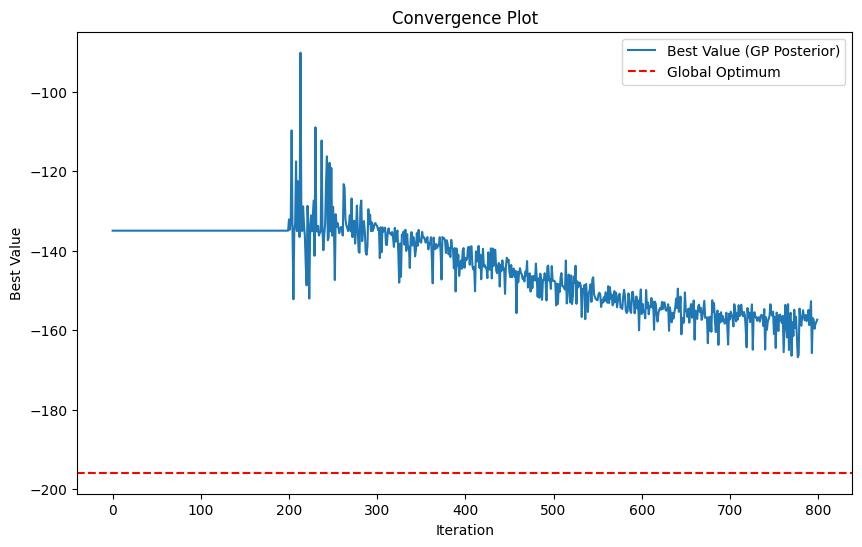

In [20]:
# 収束プロットの表示例（global_optimum が既知の場合）
global_optimum = -39.16599 * 5  # 5次元の場合の最適値

plt.figure(figsize=(10,6))
plt.plot(eci_bo_bandit_history[0], label="Best Value (GP Posterior)")
plt.axhline(y=global_optimum, color='r', linestyle='--', label="Global Optimum")
plt.xlabel("Iteration")
plt.ylabel("Best Value")
plt.title("Convergence Plot")
plt.legend()
plt.show()

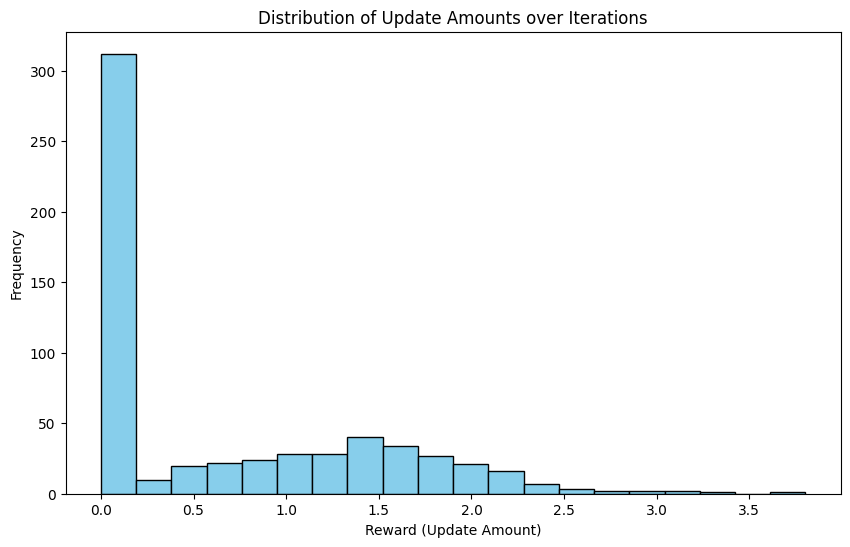

In [21]:
# 1つの試行について、更新量（reward）の分布をヒストグラムで表示
plt.figure(figsize=(10, 6))
plt.hist(bandit_list[0].reward_history, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Reward (Update Amount)")
plt.ylabel("Frequency")
plt.title("Distribution of Update Amounts over Iterations")
plt.show()
